### Дано: 
Есть данные AB-теста с 2022-11-02 по 2022-11-08. 

Группы (колонка exp_group): 1 - контрольная группа, 2 - тестовая группа.

Предположим, что на тестовых группах развертывались новые алгоритмы рекомендации постов.

### Задание:
Провести АВ-тест между группами 1 и 2. α=0.05

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#### АВ-тест между группами 1 и 2

In [36]:
df = pd.read_csv(r"C:\Users\belik\Desktop\data for ab-test.csv")

In [10]:
df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [11]:
# проверяем количество пользователей в группах 1 и 2
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


#### количество пользователей в обеих группах примерно одинаковое

In [12]:
 # настраивоем отображение гистограммы
sns.set(rc={'figure.figsize': (11.7, 8.27)})

<AxesSubplot:xlabel='ctr', ylabel='Count'>

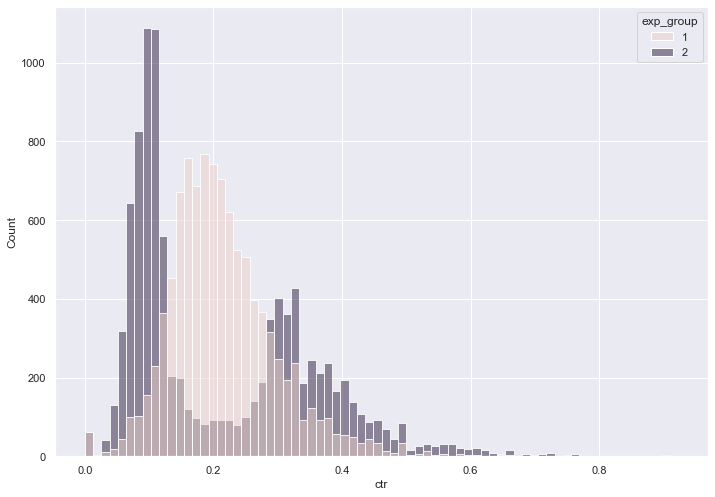

In [13]:
# визуализируем распределение значений ctr

sns.histplot(data=df, 
             x='ctr', 
             hue='exp_group', 
             alpha = 0.5, 
             kde = False)

#### Распределение группы 2 визуально не похоже на нормальное, он имеет 2 вершины. Поскольку распределение во 2 группе не похоже на нормальное, то использовать t-критерий Стьюдента мы не можем, так как этот тест очень чувствителен к распределению.

In [14]:
# с помощью теста Манна-Уитни проверим гипорезу о равенстве значений в двух выборках

stats.mannwhitneyu(df[df.exp_group == 2].ctr, df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

#### pvalue < 0.05, это означает, что статистчески не подтвержденно равенство средних двух выборок, гипотезу H0 мы не можем принять. Соответственно есть разница среди значений обеих выборок.

In [15]:
A_gt_B = 0

for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 1].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев значения выборки 2 больше значений выборки 1. Не близко к 50%')

В 44.26 % случаев значения выборки 2 больше значений выборки 1. Не близко к 50%


### Рассчитаем сглаженный CTR и посмотрим на его гистограммы распределения

In [16]:
# сглаженный ctr

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [17]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [18]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [19]:
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

C:\Users\belik\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

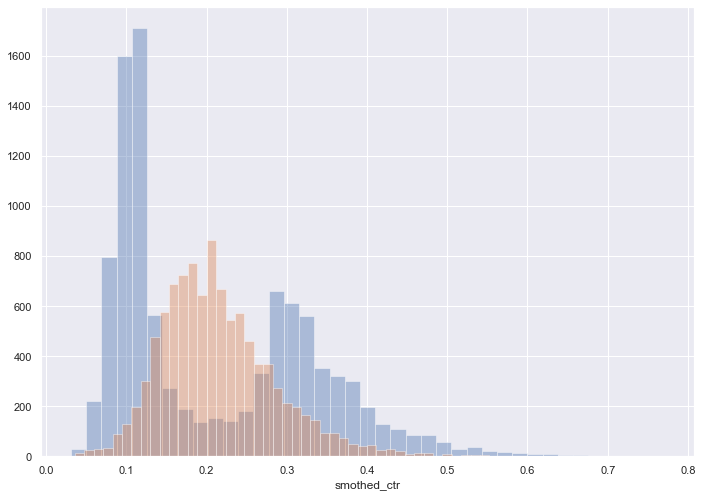

In [20]:
sns.distplot(group2.smothed_ctr, kde = False)
sns.distplot(group1.smothed_ctr, kde = False)

In [21]:
# проведем тест Манна-Уитни на сглаженном ctr

stats.mannwhitneyu(group2.smothed_ctr, group1.smothed_ctr)

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61)

#### pvalue < 0.05, это означает, что статистчески не подтвержденно равенство средних двух выборок, гипотезу H0 мы не можем принять. Соответственно есть разница среди значений обеих выборок.

### Проведем Пуассоновский бутстреп

In [22]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [23]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [24]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

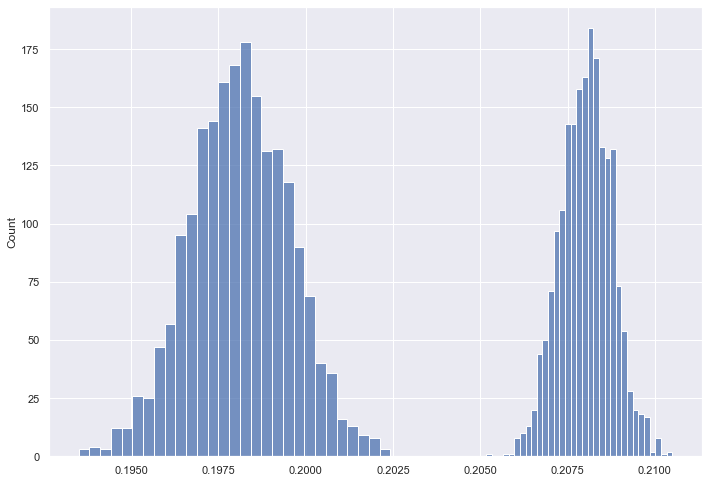

In [25]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Распределение разниц глобальных ctr на гистограмме не пересекается, соответственно в одной группе ctr значительно выше, чем в другой.

<AxesSubplot:ylabel='Count'>

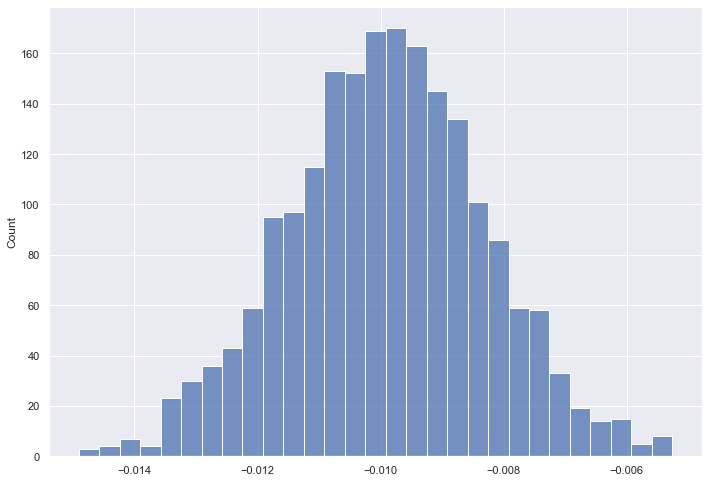

In [26]:
# Постоим гистограмму разниц между глобальными CTR 1 и 2 группы
sns.histplot(ctr2 - ctr1)

#### Гистограмма разниц глобальных ctr не пересекает 0 и находится с левой стороны от 0. Соответственно, глобальный ctr группы 1 (контрольная группа) выше глобального ctr группы 2 (группа с новым алгоритмом рекомендации постов)
#### На основании результатов Пуасоновского бутстрепа можно утверждать, что группа 1 (контрольная группа) показала лучший результат ctr, чем группа 2 (группа с новым алгоритмом рекомендации постов).

### Бакетное преобразование

In [37]:
# используем данные из файла data for ab-test bucket.csv
df_bucket = pd.read_csv(r"C:\Users\belik\Desktop\data for ab-test bucket.csv")

In [38]:
df_bucket.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


In [39]:
#тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

### pvalue < 0.05, соответственно тест Манна-Уитни поверх бакетного преобразования показал, что между группами есть различие в бакетном ctr.

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

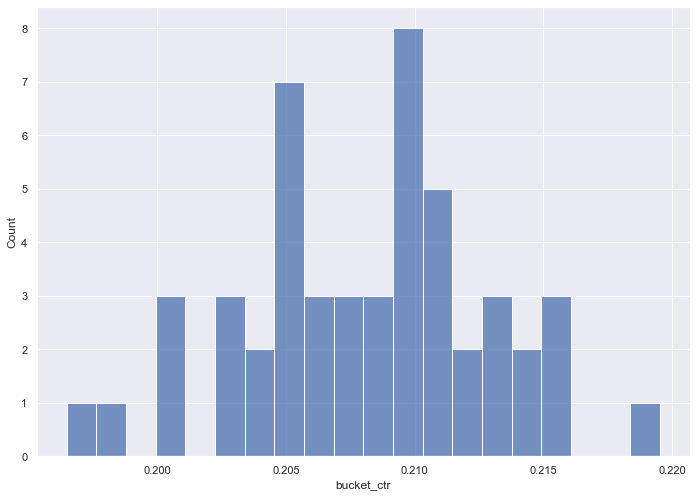

In [40]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_ctr, bins=20)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

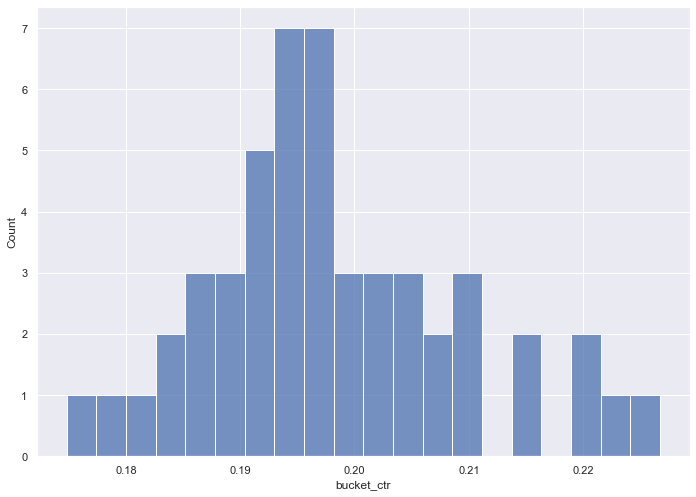

In [41]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_ctr, bins=20)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

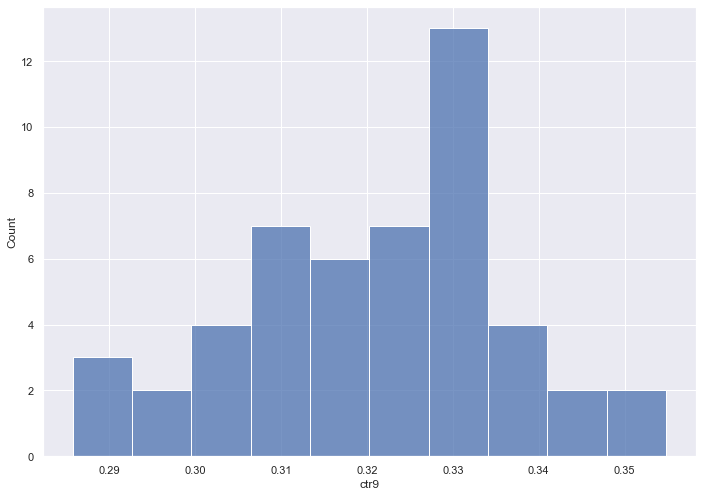

In [42]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].ctr9, bins=10)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

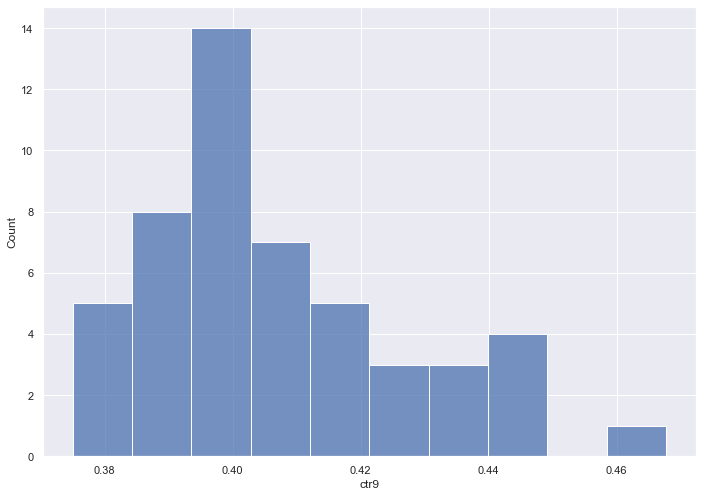

In [43]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].ctr9, bins=10)

#### распределение бакетов 90% квантиля ctr немного похоже на нормальное. сравним их с помощью t-теста и теста Манна-Уитни

In [44]:
# t-тест бакетов 90% квантиля ctr
stats.ttest_ind(df_bucket[df_bucket.exp_group == 2].ctr9, df_bucket[df_bucket.exp_group == 1].ctr9, equal_var = False)

Ttest_indResult(statistic=23.214341215937406, pvalue=1.2945537024964474e-40)

#### pvalue < 0,05, соответственно t-тест показывает различия между бакетами 90% квантиля ctr

In [45]:
#тест Манна-Уитни поверх бакетов 90% квантиля ctr
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].ctr9, 
                   df_bucket[df_bucket.exp_group == 2].ctr9,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

#### pvalue < 0.05, соответственно тест Манна-Уитни показывает, что есть разница между бакетами 90% квантиля ctr в группах 1 и 2

### Анализ на основании Линеаризованного CTR: 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [46]:
control_ctr = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [47]:
# функция для linearized_likes

def get_linearized_likes(likes, views, control_ctr):
    linearized_likes = (likes - views * control_ctr)
    return linearized_likes

In [48]:
df['linearized_likes'] = df.apply(lambda x: get_linearized_likes(x['likes'], x['views'], control_ctr), axis=1)

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

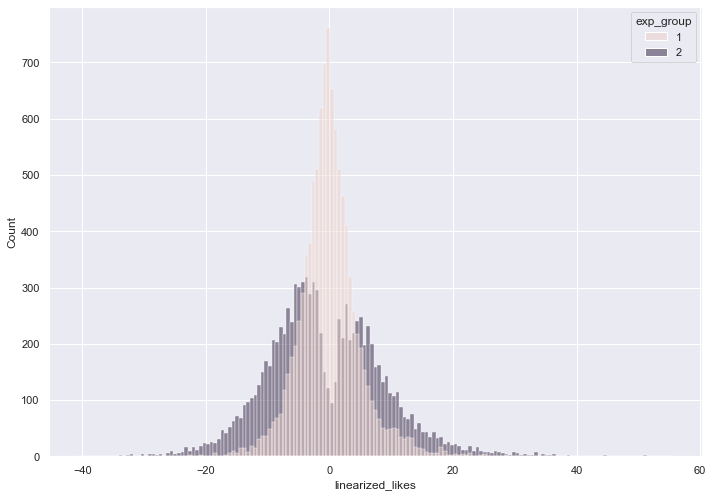

In [49]:
# визуализируем распределение значений ctr

sns.histplot(data=df, 
             x='linearized_likes', 
             hue='exp_group', 
             alpha = 0.5, 
             kde = False)

In [50]:
# с помощью теста Манна-Уитни проверим гипорезу о равенстве значений в двух выборках

stats.mannwhitneyu(df[df.exp_group == 2].linearized_likes, df[df.exp_group == 1].linearized_likes)

MannwhitneyuResult(statistic=45771671.0, pvalue=9.404319579641738e-27)

#### тест Манна-Уитни показывает, что есть различия среди значений двух выборок

In [51]:
A_gt_B = 0

for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].linearized_likes.sample().values[0] > df[df.exp_group == 1].linearized_likes.sample().values[0]
    
print('В', A_gt_B/100, '% случаев значения выборки 2 больше значений выборки 1.')

В 45.45 % случаев значения выборки 2 больше значений выборки 1.


#### Гистограммы распределения ctr показали, что распределение ctr 2 группы не похоже на нормальное и имеет 2 пика.
#### Тест Манна Уитни по ctr показал, что между группами есть различие, и 57% значений ctr выборки 1 больше выборки 2.
#### Тест Манна-Уитни поверх сглаженного ctr тоже показал различие между выборками.
#### Пуассоновский бутстреп показал, что группа 1 показала лучший результат ctr, чем группа 2.
#### Тест Манна-Уитни поверх бакетного преобразования позаказ различия у бакетных ctr и 90% квантильного ctr.
#### t-тест поверх  распределения 90% квантильного ctr показал различия между группами.
#### Тест Манна Уитни поверх Линеаризованного CTR показал, что есть различия между группами. Значения группы 1 больше значений группы 2.

### Вывод: между ctr двух выборок статистически установлена разница, контрольная группа показала лучший ctr, чем группа с новым алгоритмом рекомендации постов

### Рекомендация: не раскатывать новый алгоритм рекомендации постов на всех новых пользователей.

### Дальнейшее исследование: 2 горб распределения тестовой группы (2) показал результаты выше, чем обычный алгоритм рекомендации постов. Дополнительно необходимо проверить, почему появились 2 горба, нет ли влияния каких-нибудь непредвиденных факторов на проведения A/B-теста